*written by: Julia Knoblauch, Jana Vihs, Annika Boer, Kai Ingo Schewina*

# Explainable Recommendation Systems for Energy-Efficient Smart Home

<h2><center>Abstract</center></h2>

# Final documents:
- Assignment
- Explainability Agent:
- Performance Evaluation Agent:
- requirements.txt
- agents.py
- helper_functions.py
- (optional: adapt other agents)

# To do:

- Show explainability of Explainable Boosting CLassifier

- Annika: usage agent evaluierung von activity agent übernehmen, --> xai evaluierung: Tabelle erstellen ähnlich zu agent_scores_to_summary/ oder anders eval werte hier als Tabelle einzufügen , lime überprüfen in eval: regression ersetzt durch classification parameter?
- Jana: EBM statt DALEX, Dalex macht keinen Sinn das es vorallem Fairness between features messen kann wie Gender, Rasse, Alter etc, Macht für unseren Use Case keinen Sinn, EDA: wetterdaten -> To DO split after date and hour to detect when the tumble dryer was used multiple times of the day in context with weather data,recommendation
- Julia: SHAP chapter (SHAP eval nochmal prüfen)
- Kai: hyperparameter tuning, literature

Weiteres:
- citation: manuell und references mit programm
- hyperparameter tuning: über performance evaluation agent
- Eval allgemein schonmal laufen lassen und eventuell modelle ausschließen für xai-evaluation
- measure for interpretability/understandability: disregard because we just apply the same appraoches on all to get recommendation?
--> zu schwammig: kein gutes proxy weil anpassbar
- weitere packages checken: DALEX (siehe unten)
- EDA: auf germain paper anpassen und für weather updaten
- evaluierung runnen für (alle) households
- explanability agent erstellen: outcome explainability des activity_agents & usage agents zusammenführen für recommendation
- formalisierung
- (other datasets)

Sammlung Hinweise:
- warning bei usage/load wenn man evaluierung runnt zu format --> beheben?
(warning bei auc/load: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().)
- xgb: use_label_encoder=False eingestellt damit warning weg geht: problem?
- explainability evaluation atm only test first 3 rows (set to len(X_test)) for final eval

## Table of contents - cleaned
1. Introduction
2. Literature Review
    
    2.1 Explainable AI:
    
    2.2 Recommender Systems in SH
    
    2.3 Explainability in RS

3. Methodology

    3.1 Recommender System

    3.2 Algorithms XAI
        - Taxonomy: Auswahl
        - Model-intrinsic: logit, knn, rf(?), gam
        - Model-agnostic
            Feature Importance: LIME, SHAP, plus evtl. CIU, DALEX, MAPLE
    
    3.3 Algorithms prediction:
    adaboost, xgboost

4. Experimental Design
    
    4.1 data organization
    
    4.2 Evaluation
        - Performance
        - Explainability

5. Results
   
    5.1 Performance
   
    5.2 Explainability
   
    5.3 Umbenennen: Decision for model & XAI model
   
    5.4 Final result of RS: Recommendation + Explanation

6. Discussion
    - Contributions
    - Limitations
    - Implications
    - Recommendations
    - Future Research

7. Conclusion

References

## Table of contents

1. Introduction:
    - Problem setting: ?

2. Literature Review (Kai) --> Tabelle
    - Explainable AI (XAI): Julia, Annika
    - Recommender Systems in SH: Fokus
    - Explainability in RS: Fokus
3. Methodology (i.e., the ML techniques that you apply)
    - Recommender System??
    - Algorithms XAI
        - Taxonomy: Auswahl (Annika)
        - Model-intrinsic (Annika)
        - Model-agnostic (Machine Learning Interpretability: A Survey on Methods and Metrics)
            - LIME (Annika)
            - SHAP (Julia)
            - EBM (Jana)
        - vorgestellte Tabelle aus Präsi formaler --> Vergleich
    - Algorithms prediction (Jana, Formel für finales Modell, mit paper)
        xgboost, adaboost, knn, logit, rf, EBM

4. Experimental Design (including EDA, data organization, performance measures, etc.)
    - data organization (+ EDA von denen auf Wetterdaten + NAs Wetterdaten)
        - agents system (Bild) (Jana)
        - restriction to 2 households
        - with & without weather data (EDA, Struktur, Herkunft) (Kai)
    - Evaluation
        - Performance (Kai?)
        - Explainability (feature importance) (Julia)
5. Results
    - Performance (Kai?)
    - Explainability (Julia, Annika)
    - umbennenen: Decision for model & XAI model
    - Final result of RS: Recommendation + Explanation (Jana)
6. Discussion (Kai)
    - ...
    - Contributions
    - Limitations: making usage daily
    - Implications
    - Recommendations
    - Future Research: Neural Networks, mehrere recommendations pro Tag,

e.g. include:
    - no user
    - runtime problems
        - api weather data 
        - 4 models, 20 households
        - Beispiel, wie lange es dauern würde, eine recommendation zu laden (aber nur 1x am Tag)

7. Conclusion: zusammenfassung in 2 abschnitten
References

In [104]:
# Necessary packages to run notebook:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,5)

from IPython.display import Latex
from IPython.display import Image

from helper_functions import Helper
from agents import Performance_Evaluation_Agent
from agents import Preparation_Agent
from copy import deepcopy

helper = Helper()


In [2]:
# Data
DATA_PATH = '../data/'

## 1. Introduction

## 2. Literature Review
https://christophm.github.io/interpretable-ml-book/
https://github.com/wangyongjie-ntu/Awesome-explainable-AI

### Explainable AI (XAI)
4 Richtungen der local approaches kurz zusammenfassen:
**Feature Importance (FI)**
**Rule Based (RB)**
**Prototypes (PR)**
**Counterfactuals (CF)**

-->+/- der appraoches nennen damit man in 3. erklären kann dass man FI nimmt und die Vorteile von RB
durch den Output als Liste.

### Criteria for XAI (Julia)

Robnik-Šikonja and Bohanec (2018) suggested properties of the explainers that differentiate the appraoches:
- Expressive Power: What logic does the explanation follow and which languge do they display?
- Translucency: Does the model decompose the predictive model (decomposition), treat the model as blackbox (pedagocial) or mix these approaches?
- Portability: Can the model be used on multiple predictive models i.e. is it model specific or agnostic?
- Algorithmic complexity: How time consuming are the computations?

Carvalho et. al (2019) propose additional properties that are useful in our situation:
- Stability: How stable are the explanations?
- Data Sampling: How is the data sampled e.g. for shapley value estimation?
- Shuffling/Permutation: How does the algorithms shuffle the data to derive the feature importance?

The explainability appproaches will be evaluated on these critera in section 3.

Additionally, there are three options to evaluate the explainability approaches (Doshi-Valez & Kim, 2018).
Firstly, *Application grounded Evaluation* involves using humans in the real setting i.e. we need subjects that use our
recommender system in their smart home and evaluate the usefulness of the offered explanation. Secondly, another possibility
would be to use *Human-grounded Metrics* that would involve humans but not necessarily include the explanability
appraoch in a real task. In our case we could do experiments in which subjects have to choose between the explanability
approach e.g. based on their preference.
Thirdly, Doshi-Valez and Kim (2018) propose *Functionally-grounded Evaluation* that use proxies to evaluate the
explainability approach.
We will use the third approch as evaluations that involve the actual application of the recommender system are out of scope
for this seminar and the evaluation with humans and simplified tasks might not offer much external validity to the real setting.
*Could also be part of dicussion/ Future research to show different versions of our final output and what users like/disklike*

We will introduce the proxies for evaluation of the explanations in chapter 4.

### Recommender Systems in SH: Fokus

#### Explainability in RS: Fokus

## 3. Methodology

### 3.1 Recommender System

### 3.2 XAI Alogorithms
### Taxonomy?

### Model intrinsic
paper:
https://arxiv.org/pdf/1811.10154.pdf
https://arxiv.org/abs/2006.06466

Logit as benchmark?, GAMMLI, Random Forest (?)
### Model Agnostic Approaches

### LIME
To do:
Is mode= 'regression' correct?/ I changed it to classification but checking again if correct

xgboost: resources to implement
https://github.com/marcotcr/lime/issues/334
https://github.com/adriamoya/xgboost_default_companies/blob/master/main.py
mention current approaches (no implementation as far as I know except SP-LIME for global)
https://arxiv.org/abs/2106.07875

Benchmarking and Survey of Explanation Methods for
Black Box Models - see chapter 4.1 for variants of LIME

https://arxiv.org/abs/2012.00093

### SHAP (Julia)
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fwww.jmlr.org%2Fpapers%2Fvolume11%2Fstrumbelj10a%2Fstrumbelj10a.pdf&clen=690800&chunk=true
--> AnEfficient Explanation of Individual Classifications using Game Theory (2010)

Aktuell implementiert für KernelExplainer: vorher kmeans weil viel schneller
aber keine info zu tradeoff und keine wirklichen recommendations wie k= gesetzt werden sollte


### Other approaches to research:
https://www.linkedin.com/posts/hima-lakkaraju-b130217_himachilpptx-activity-6814735906092703744-fOYe/
https://interpretable-ml-class.github.io/
https://github.com/anguyen8/XAI-papers
https://towardsdatascience.com/the-how-of-explainable-ai-explainable-modelling-55c8c43d7bed
https://github.com/SeldonIO/alibi
https://github.com/pbiecek/xai_resources
https://github.com/interpretml/interpret

Don't put in eval but maybe mention:
**MUSE**
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fcs.stanford.edu%2Fpeople%2Fjure%2Fpubs%2Fexplanations-aies19.pdf&clen=1929781&chunk=true
"Faithful and Customizable Explanations of Black Box Models"
--> give concrete measures for xai other than fidelity
but: not open source package?

slides:
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Finterpretable-ml-class.github.io%2Fslides%2FLecture_11.pdf&clen=1064587&chunk=true

Don't put in eval but maybe mention:
**BETA**
https://arxiv.org/pdf/1707.01154.pdf
Interpretable & Explorable Approximations of Black Box Models
--> global approach, no package

from paper Bodria et. a. (2021):
see table 1 for overview on what else we could look at


Don't put in eval but maybe mention:
**py-ciu**
https://arxiv.org/abs/2006.00199
Explanations of Black-Box Model Predictionsby Contextual Importance and Utility
https://github.com/TimKam/py-ciu
--> also nice because working textual output
--> aber: kein prediction model daraus

**MAPLE**
-> check if they do surrogate model/ we would need to add to eval
https://github.com/GDPlumb/MAPLE
https://arxiv.org/abs/1807.02910
aber keine ahnung wie output ist & schlechte documentation

### 3.3 Prediction Algorithms


The following classical prediction algorihms were used:

**K-Nearest-Neighbour**: A classification algorithm (Cunningham et. al 2020), where examples are classified based on the class of thir nearest neighbours.

**Logistic Regression**:

**Random Forest**: A combination of tree predictors, where each tree depends on the values of a random vector sampled independently and with the same distribution for all trees in the forest (Breiman, 2001).

**XGBoost** : A scalable end-to-end tree boosting system , which is used widley by data scientists to achieve state-of-the-art results.

**AdaBoost**:

NOCH ANDERS SCHREIBEN!
Some of the above models are intrinsically explainable, while others need to be explained by model agnostic approaches. 

To include a global explainability approach we decided to include the following model.

**Explainable Boosting Maschine**: A glassbox model, which is a generalized additive model (GAM) of the form 
$$g(E[y]) = \beta_{0} + \sum f_{j}(x_{j}),$$ where $g$ denotes the link function which adapts the GAM to different application settings like classification or regression (H. Nori et. al. 2019). It is being highly intelligibile and explainable while being designed to have accuracy comparable to state-of-the-art machine learning models like Random Forest and Boostes Trees. Further, it is an additive model, which means that each feature contributes to predictions in a modular way. Hence, it is easy to reason about the contribution of each feature to the prediciton.

## 4. Experimental Design 



### Data

Consists of 6 different Agents which tackle different tasks. The acutal Recommendation Agent combines the output of the Usage Agent, the Load Agent and the Availability Agent which obtain there input data from the Preparation Agent. Further Information can be found in *ref*.
During our research we extended the current Multi-Agent in place by an Explainability Agent, combines the Explainability output of the usage and Availability Agent.

The underlying data consist out of the REFIT Data which are Electrical Load Measurements provided by Murray et al. (2017). The data contains the energy consumption of nine different devices in Watts used in 20 households in the United Kingdom as well as the aggregate energy consumption in each household over the period 2013 to 2015. As the data only contains these energy consumption measured at eight-second intervals, we need to perform a few preparation steps including aggregating the data, cleaning the data, creating our target features and further feature creation. This task is tackled by the Prepapration Agent.
In order to improve our current Multi-Agent we extended our data set with specific weather features using the API from meteostat https://github.com/meteostat/meteostat-python.
The weather might be of cruical importance for the usage of some devices, e.g a Tumble Dryer in a household. Hence we scraped the following additional features

*dwpt* : The dew point in °C 

*rhum*: The relative humidity in perecent (%)

*temp* : The air temperature in °C

*wdir* : The average wind direction in degrees (°)

*wspd* : The avaerge wind speed in km/h

For some data points there existed missing values which where imputeb by using KNN.



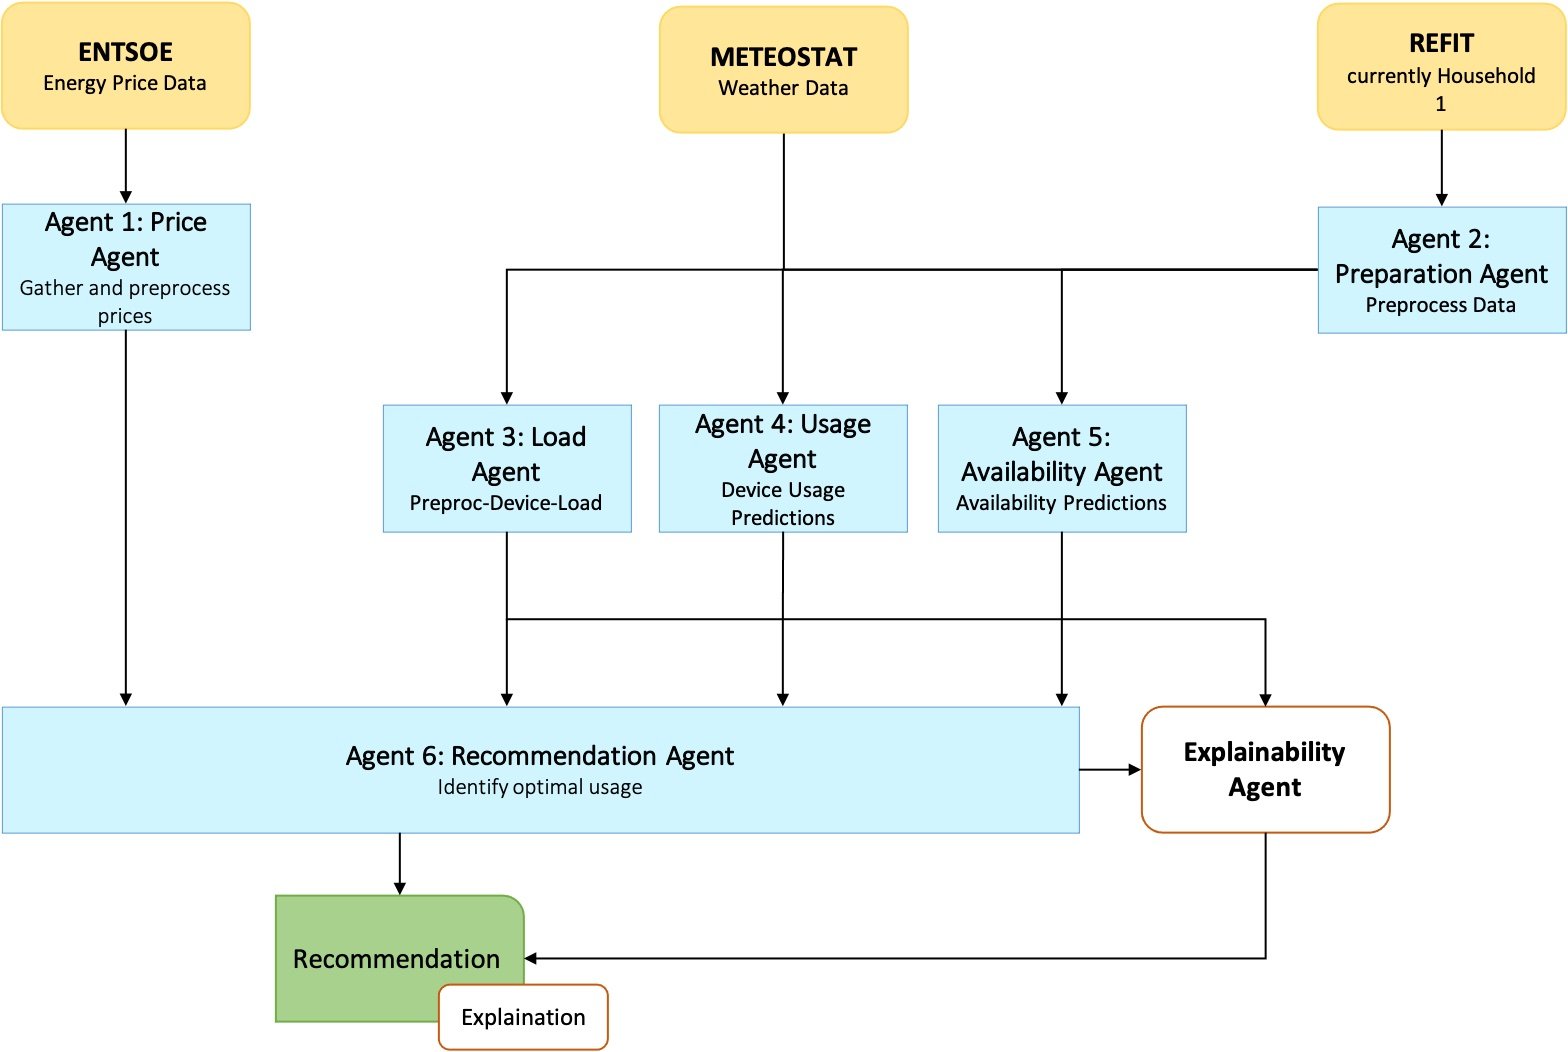

In [3]:
Image(filename='../pictures/structure.jpg')

### Explorative Data Analysis




In [10]:
truncation_params = {
    'features': 'all', 
    'factor': 1.5, 
    'verbose': 1
}

scale_params = {
    'features': 'all', 
    'kind': 'MinMax', 
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}

shiftable_devices = ['Tumble Dryer', 'Washing Machine', 'Dishwasher'] # computer und tv sind m. E. non-shiftable, VR

device_params = {
    'threshold': 0.15
}

load_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'shiftable_devices': shiftable_devices, 
    'device': device_params
}

# Load household and preprocess
household_id = 3
household = helper.load_household(DATA_PATH, household_id, weather_sel=True)
output, scaled, df = Preparation_Agent(household).pipeline_load(household, load_pipe_params)

[outlier truncation: Unix]: 100%|██████████| 6994594/6994594 [00:11<00:00, 586148.11it/s]
[outlier truncation: Unix]: 0 outliers were truncated.


[outlier truncation: Aggregate]: 100%|██████████| 6994544/6994544 [00:16<00:00, 416267.46it/s]
[outlier truncation: Aggregate]: 828082 outliers were truncated.


[outlier truncation: Toaster]: 100%|██████████| 14697/14697 [00:00<00:00, 587530.36it/s]
[outlier truncation: Toaster]: 3900 outliers were truncated.


[outlier truncation: Fridge-Freezer]: 100%|██████████| 3720281/3720281 [00:07<00:00, 472108.00it/s]
[outlier truncation: Fridge-Freezer]: 436403 outliers were truncated.


[outlier truncation: Freezer]: 100%|██████████| 2834030/2834030 [00:04<00:00, 644065.71it/s]
[outlier truncation: Freezer]: 263181 outliers were truncated.


[outlier truncation: Tumble Dryer]: 100%|██████████| 281702/281702 [00:00<00:00, 783130.75it/s]
[outlier truncation: Tumble Dryer]: 0 outliers were truncated.


[outlier truncation: Dishwasher]: 100%|█████████

<AxesSubplot:title={'center':'Correlation of weather features'}>

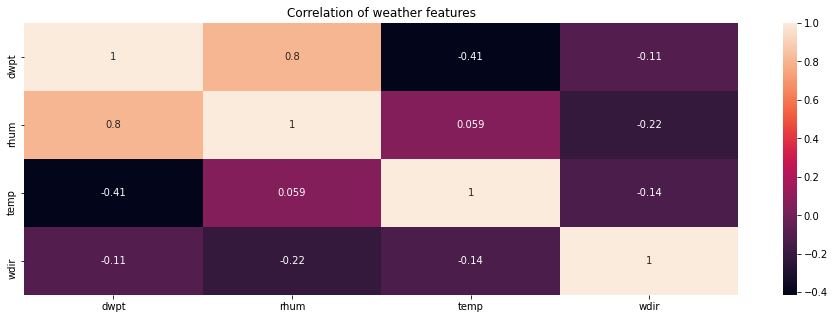

In [105]:
plt.title('Correlation of weather features')
weather_df = df[['dwpt', 'rhum', 'temp', 'wdir']]
sns.heatmap(weather_df.corr(), annot=True)

In [75]:
df_27_09_2013 = df[['dwpt','rhum','temp','wdir','wspd','Tumble Dryer_usage']].filter(like='2013-09-27', axis=0)
df_27_09_2013


,dwpt,rhum,temp,wdir,wspd,Tumble Dryer_usage
Time,,,,,,
2013-09-27 00:00:00,0.50000,0.588889,0.750000,0.342857,0.147368,0
2013-09-27 01:00:00,0.46875,0.585185,0.819444,0.285714,0.147368,0
2013-09-27 02:00:00,0.50000,0.588889,0.750000,0.314286,0.123684,0
2013-09-27 03:00:00,0.46875,0.585185,0.819444,0.342857,0.123684,0
2013-09-27 04:00:00,0.50000,0.588889,0.750000,0.371429,0.100000,0
2013-09-27 05:00:00,0.46875,0.585185,0.819444,0.314286,0.123684,0
2013-09-27 06:00:00,0.46875,0.585185,0.819444,0.285714,0.100000,0
2013-09-27 07:00:00,0.46875,0.551852,0.750000,0.342857,0.100000,0
2013-09-27 08:00:00,0.50000,0.588889,0.750000,0.257143,0.147368,0


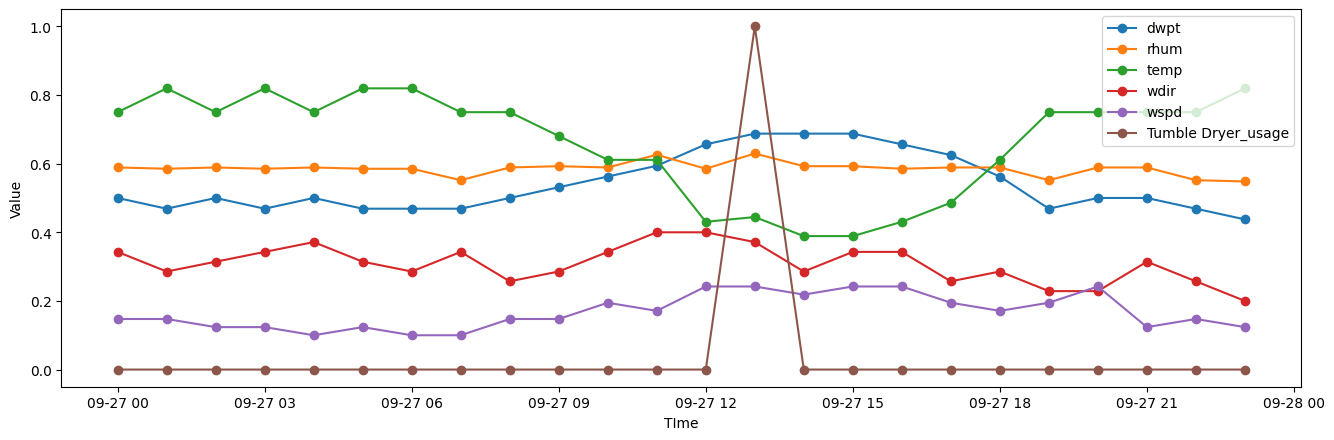

In [89]:
# Draw Plot

def plot_df(df, x, y, title="", xlabel='TIme', ylabel='Value', dpi=100, axvspan=True):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, marker='o')
    plt.legend(df_27_09_2013.columns.tolist())
   
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_27_09_2013, x=df_27_09_2013.index, y=df_27_09_2013.values, title='')  


In [113]:
tumble_dryer_inuse = df[df['Tumble Dryer_usage']==1][['dwpt','rhum','temp','wdir','wspd']]
tumble_dryer_inuse.head(50)

,dwpt,rhum,temp,wdir,wspd
Time,,,,,
2013-09-26 13:00:00,0.65625,0.585185,0.430556,0.257143,0.242105
2013-09-27 13:00:00,0.68750,0.629630,0.444444,0.371429,0.242105
2013-09-28 08:00:00,0.40625,0.588889,1.000000,0.142857,0.123684
2013-09-28 13:00:00,0.75000,0.588889,0.291667,0.228571,0.317105
2013-09-28 14:00:00,0.75000,0.588889,0.291667,0.228571,0.293421
2013-09-28 15:00:00,0.75000,0.629630,0.347222,0.257143,0.317105
2013-09-29 06:00:00,0.46875,0.629630,0.916667,0.171429,0.242105
2013-09-29 07:00:00,0.46875,0.629630,0.916667,0.171429,0.171053
2013-09-29 08:00:00,0.50000,0.629630,0.833333,0.171429,0.194737


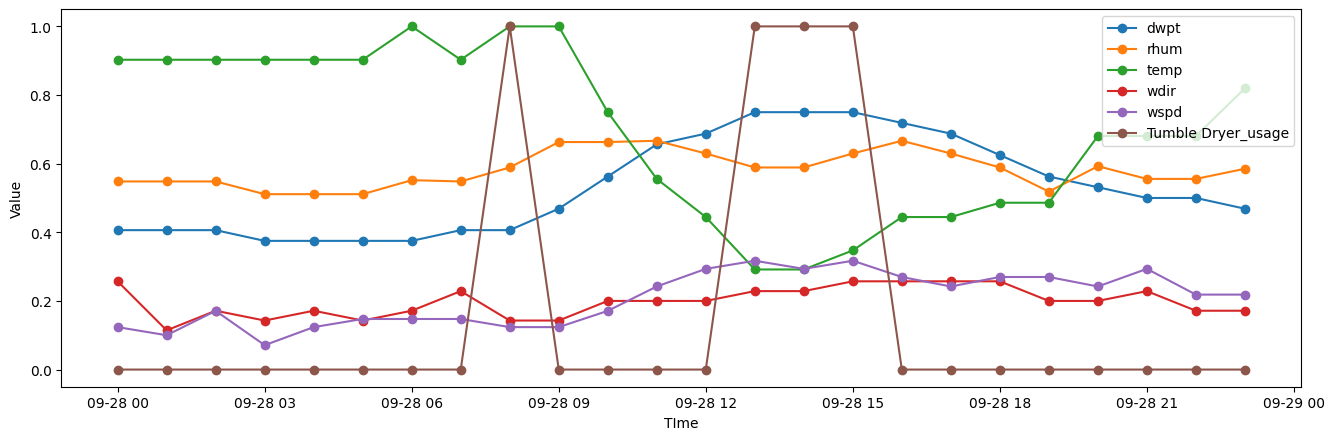

In [103]:

df_28_09_2013 = df[['dwpt','rhum','temp','wdir','wspd', 'Tumble Dryer_usage']].filter(like='2013-09-28', axis=0)
plot_df(df_28_09_2013, x=df_28_09_2013.index, y=df_28_09_2013.values, title='')


### Evaluation

#### Performance (Kai)

#### Explainability (Julia)

*altueller stand: in literature research properties of explainability models und hier konkrete metrics*

When is comes to our evaluation of the explainability approaches we want to quantitatively compare the
individual explainations that the models offer. The literature does no propose one clear framework
 which metrics to use as it is also highly application depenednt.
Nevertheless, we will use the following concepts that are widely applied to determine how well
 the explainability approaches work (Carvalho et. al, 2019):

**Accuracy** Similar to predictive accurary, the accuracy of the explanation method refers to how well the explainable model
predicts unseen instances compared to the real outcome. We will use the standard measure of accuracy, precicion and recall.
Note: accuracy might be misleading since imbalanced?

**Fidelity** This criteria determindes how close the prediction from the explainale model is to the black-box model.
Therefore, fidelity describes how well the explainability model is able to imitate the prediction of the black-box model.
We will again use the measure used for accuracy but replace the target label by the predictions from the black-box model.
Note that Carvalho et. al (2019) mention an interrelation between these two concepts: black-box models with high predictive
accuracy and explainations that offer a high fidelity are also highly accurate when it comes to the real predictions. This is
the ideal that we would like to achieve.

Additionally, we calculate the *Mean-Squared-Explainabilty Error* (MSEE) for every approach to measure not only if
the decicion of the black-box model and the explainability approach is the same but also to measure how close they are to each other.
This metrics represents how well the explainability approaches are calibrated. The formula of the traditionally used
Mean-Squared-Error is adapted in the following way: *citation missing*

$$ MSEE_{} = \frac{1}{n} (y_{pred} - y_{expl})^2 $$


**Interpretability/ Comprehensibility/ Understandability** This critera deals with how well humans actually
 understand the explanations. Since we have decided on functionally-grounded evaluations
we have to rely on proxies like ...
*hm entweder vlt das erst danach vergleichen z.b. fidelity für verschiedene anzahl and features?
oder: ??
oder: nicht vergleichen und sagen dass wir dadurch dass wir
alles am ende auf den selben output bringen, dass das nicht nötig ist?*
--> hier noch citation wenn was gefunden was wir machen könnten: am coolsten wäre ein plot iwie

**Efficiency** Lastly, we will evaluate how efficient the explainability appraoches are in calculating
the local explanations. To the end we will measure the time that each method needs to calculate all the
local explanations for a day and average the values.

Zur Info:
--> Precicion (What proportion of positive identifications was actually correct?)
--> Recall (What proportion of actual positives was identified correctly?)

## Results

### Performance

### Explainability

### Umbenennen: Decision for model & XAI model

### Final result of RS: Recommendation + Explanation
Note:  Carvalho et. al (2019) mention criteria for Human-friendly explanations that we could include here for reasoning
our final explanation approach


## 6. Discussion 

### Contributions


### Limitations 


So many different approaches. Available Github Repos but dependencies cause several conflicts due to different package versions.
Missing user data. To evaluate the explainability approach from a human perspektive ot would be of cruical importance to measure users trust and acceptance 

### Implications

### Future Research

Gammli- Generalized Additive Modeling with Manifest and Latent Interactions, several recommendations per day.

paper: 'Human-in-the-Loop Interpretability Prior'
paper: https://dl.acm.org/doi/abs/10.1145/3351095.3375624

## 7. Conclusion

## References

1. "InterpretML: A Unified Framework for Machine Learning Interpretability" (H. Nori, S. Jenkins, P. Koch, and R. Caruana 2019)
2. Cunningham, Padraig & Delany, Sarah. (2020). k-Nearest Neighbour Classifiers -- 2nd Edition. 
3. Tianqi Chen and Carlos Guestrin. XGBoost: A scalable tree boosting system. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, KDD ’16, pages 785–794, New York, NY, USA, 2016. ACM. ISBN 978-1-4503- 4232-2. doi: 10.1145/2939672.2939785. URL http://doi.acm.org/10.1145/2939672. 2939785.
4. Breiman, Leo. (2001). Machine Learning, Volume 45, Number 1 - SpringerLink. Machine Learning. 45. 5-32. 10.1023/A:1010933404324. 